# Task: Construct Neural Network Models to Diagnose Pneumonia Using Chest X-ray Images

* Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.

\
* Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems.

### Chest X-Ray Image Data

* You can register in Kaggle and download the dataset here: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

\
* The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

\
* Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou, China. All chest X-ray imaging was performed as part of patients’ routine clinical care.

\
* For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

\
* See the publication here: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

###Q1.
Download and save the dataset to your Google Drive. Mount your Google Drive to Colab to access the dataset.

Create three lists for the train, val, and test images seperately. Each list contains the full paths of the images, for example:
```
image_paths_train = [path1, path2, path3, ...]
```
There should be 5216, 16, 624 paths in the train, val, and test lists, respectively.

Hint: Some sample code you may choose to use (or feel free to develop your own):
```
## Gether all img paths into a dictionary, which takes the following format:
# {('train', 'normal'): [path1, path2, path3, ...],
#  ('train', 'pneumonia'): [path4, path5, path6, ...],
#  ('val', 'normal'): [path7, path8, path9, ...],
#  ('val', 'pneumonia'): [path10, path11, path12, ...],  
#  ('test', 'normal'): [path13, path14, path15, ...],
#  ('test', 'pneumonia'): [path16, path17, path18, ...],
# }

# Define the overall folder containing train, val, and test subfolders
import os
import glob
path = '/content/drive/MyDrive/Deep Learning Course/Datasets/chest_xray'

# Gether all img paths into the dictionary by set and type
lst_sets = ['train', 'val', 'test']
lst_classes = ['normal', 'pneumonia']
dic = {}
for set_i in lst_sets:
  for class_i in lst_classes:
    dic[(set_i, class_i)] = glob.glob(os.path.join(path, set_i, class_i, "*.jpeg"))

# Take a look a that the dictionary keys
dic.keys()

# Combine the two lists concerning the train set, the val set, and the test set,
# so that we have a list containing all img paths for the train set,
# a list for the val set, and a list for the test set
image_paths_train = dic[('train', 'normal')] + dic[('train', 'pneumonia')]
image_paths_val = dic[('val', 'normal')] + dic[('val', 'pneumonia')]
image_paths_test = dic[('test', 'normal')] + dic[('test', 'pneumonia')]

# Check the number of imgs in the train, val, and test lists
len(image_paths_train), len(image_paths_val), len(image_paths_test)
```

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image

In [ ]:
# full paths
path_train_normal = '/content/drive/MyDrive/chest_xray/train/NORMAL/'
path_train_pneumonia = '/content/drive/MyDrive/chest_xray/train/PNEUMONIA/'
path_test_normal = '/content/drive/MyDrive/chest_xray/test/NORMAL/'
path_test_pneumonia = '/content/drive/MyDrive/chest_xray/test/PNEUMONIA/'
path_val_normal = '/content/drive/MyDrive/chest_xray/val/NORMAL/'
path_val_pneumonia = '/content/drive/MyDrive/chest_xray/val/PNEUMONIA/'

# move the content of each path into a list
list_train_normal = glob.glob(path_train_normal + '*.jpeg')
list_train_pneumonia = glob.glob(path_train_pneumonia + '*.jpeg')
list_test_normal = glob.glob(path_test_normal + '*.jpeg')
list_test_pneumonia = glob.glob(path_test_pneumonia + '*.jpeg')
list_val_normal = glob.glob(path_val_normal + '*.jpeg')
list_val_pneumonia = glob.glob(path_val_pneumonia + '*.jpeg')

# combine NORMAL and PNEUMONIA datasets
train = list_train_normal + list_train_pneumonia
test = list_test_normal + list_test_pneumonia
val = list_val_normal + list_val_pneumonia

print('Number of images in the train set')
len(train)
print('\n')
print('Number of images in the test set')
len(test)
print('\n')
print('Number of images in the validation set')
len(val)

Number of images in the train set


5216



Number of images in the test set


624



Number of images in the validation set


16

In [ ]:
train[0]

'/content/drive/MyDrive/chest_xray/train/NORMAL/IM-0519-0001-0001.jpeg'

###Q2.
Show the first image in the list of train images. Note that our images have a channel of 1, so they are gray images and you may want to show the images that way.

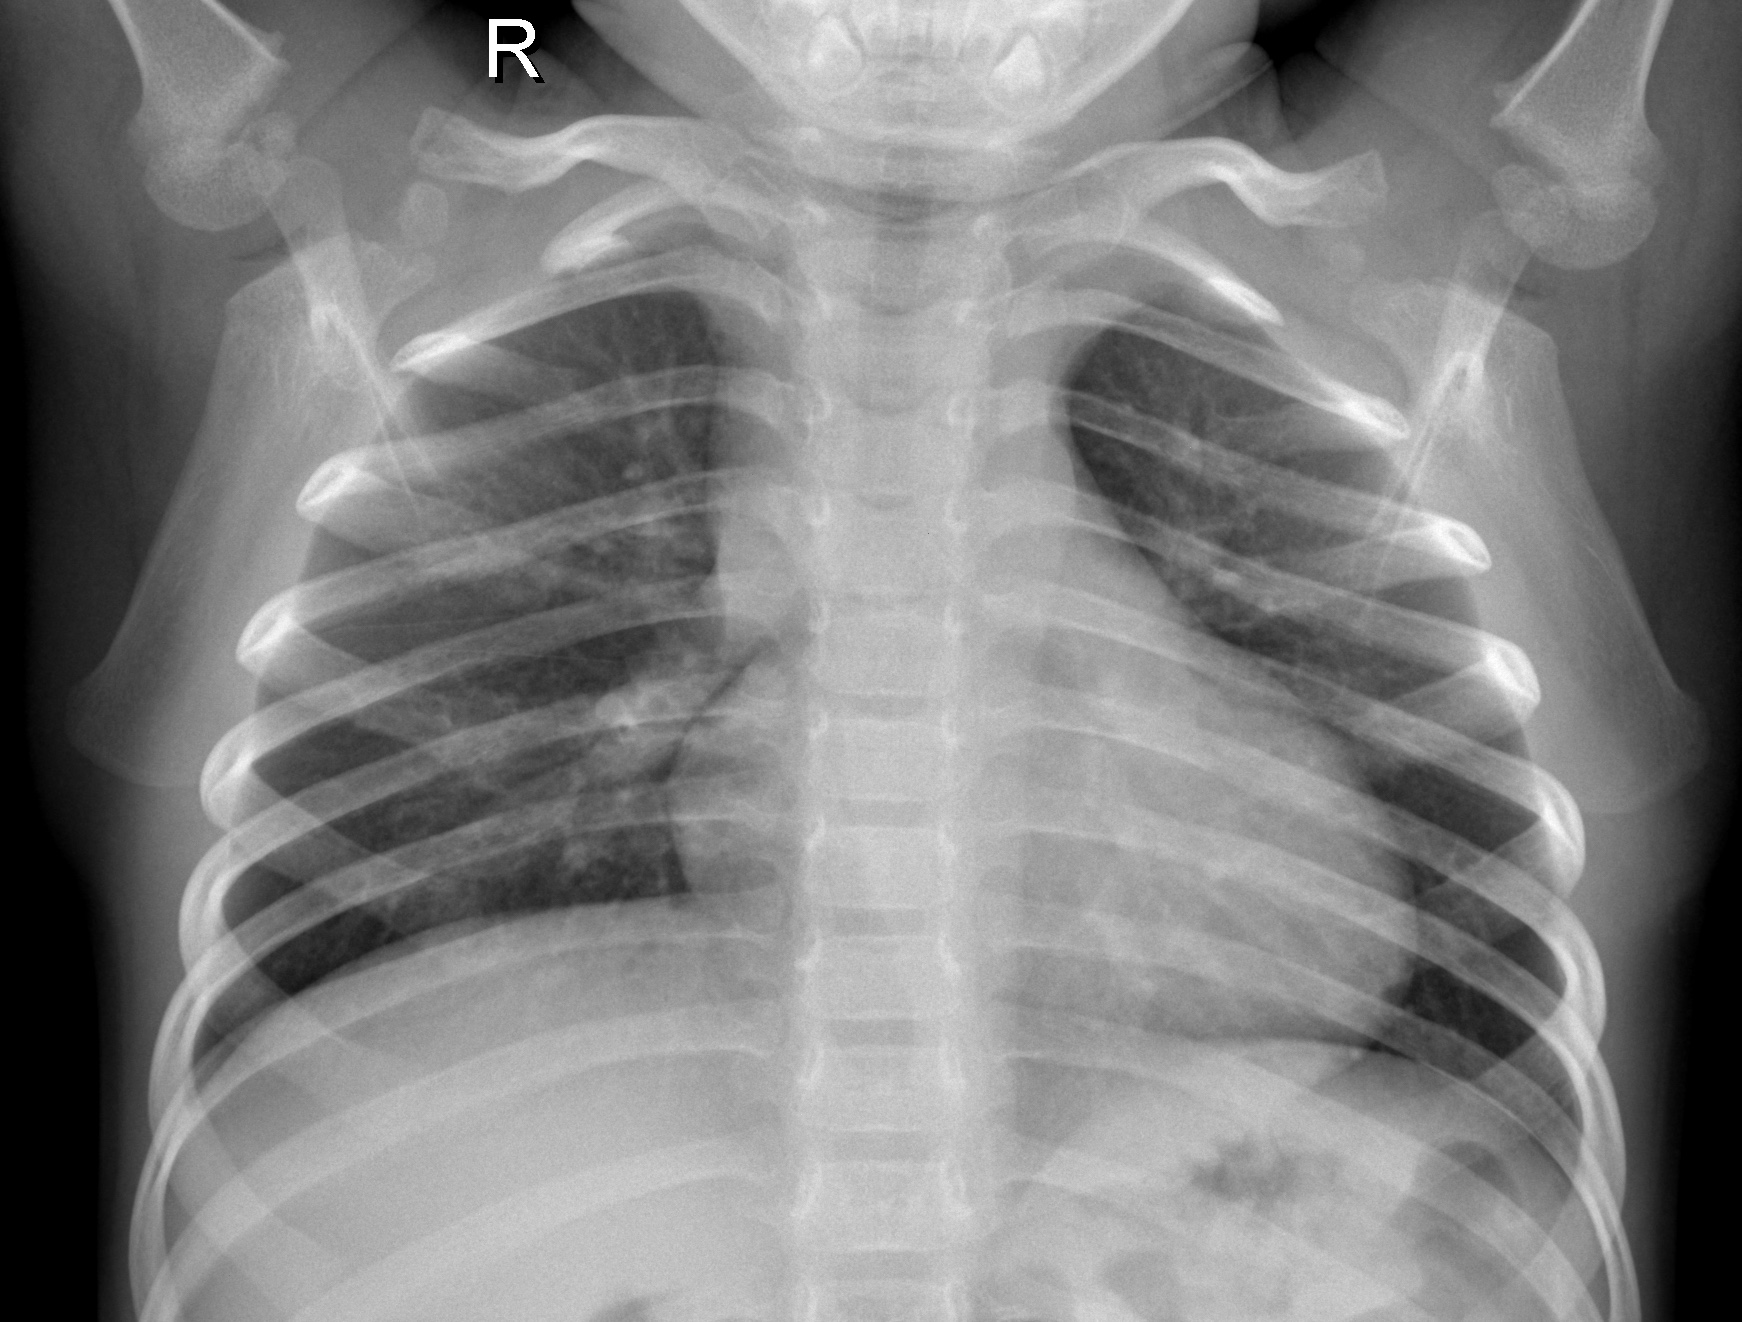

In [ ]:
img = Image.open(train[0])
img

###Q3.
Create a dictionary to map labels to integers/indices.
Hint: Use the code:
```
class_to_idx = {'normal': 0, 'pneumonia': 1}
```

In [ ]:

class_to_idx = {'NORMAL': 0, 'PNEUMONIA': 1}

###Q4.
Now we will define a customized Dataset Class. The Dataset Class will help us convert our x-rays image sets to Dataset format and load them into the DataLoaders for modeling. Remember that your customized Dataset Class should should inherent from its parent Dataset Class, and have the following required components: the constructor ```__init__```, the ```__len__``` method, and the ```__getitem__``` method. The Dataset Class should return a tuple of (image, label).

\
Hint: There are multiple ways to build a customized Dataset Class. Feel free to use the code below or write your own:
```
## Define a customized Dataset
from keras.preprocessing.image import load_img
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Define the customized Dataset class by inheriting from the parent Dataset class
class MyDataset(Dataset):

  # Define the constructor
  def __init__(self, image_paths, transform = False):
    self.image_paths = image_paths
    self.transform = transform
  
  # __len__ method is required by Dataset class
  def __len__(self):
    return len(self.image_paths)

  #  __getitem__ method is required by Dataset class
  def __getitem__(self, idx):
    # Obtain the path of an image and open the image
    image_filepath = self.image_paths[idx]
    image = load_img(image_filepath, color_mode = "grayscale")
    # Obtain the label of the image and
    # Convert it to index using the predefined dictionary
    label = image_filepath.split('/')[-2]
    label = class_to_idx[label]
    # Transform the image if a transformation function is given
    if self.transform:
      image = self.transform(image)
    # Return the (img, label) tuple
    return image, label
```

In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):

  def __init__(self, im_paths, transform=False):
    self.im_paths = im_paths
    self.transform = transform

  def __len__(self):
    return len(self.im_paths)

  def __getitem__ (self, index):
    im_pathway = self.im_paths[index]
    im = Image.open(im_pathway)
    label = im_pathway.split('/')[-2]
    label = class_to_idx[label]
    if self.transform:
      im = self.transform(im)
    return im, label

###Q5.
Remember that we usually want to do some transformations (called preprocessing and/or data augmentation) to the data before feeding them to the neural network. Some common transformations for images may include: convert the data range from 0-255 (integers) to 0-1 (floats), and normalization (so that data will have a mean of 0 and a std of 1). In addition, you may notice that our x-ray images have different sizes (height x width), which creates a challenge for neural network models, which usually require input images to have the same size (height x width).

\
Therefore, to allow data transformation, you may need to resize the images to 64 x 64 (height x width), conver them to NumPy arrays, devide each number in the arrays by 255.0 to rescale them to the range of 0-1, and then calculate the mean and std of your train set. You will need those two numbers in your transforms function.

\
Hint: Your calculate mean and std should be close to (not necessarily the same) 0.482 and 0.237, respectively.


In [ ]:
def mean_std(list):
  converted_list = []
  for i in list:
    image = Image.open(i).convert('L')
    image = image.resize((64,64))
    im_array = np.asarray(image)
    im_array = im_array / 255
    converted_list.append(im_array)
  mean = np.mean(converted_list)
  std = np.std(converted_list)
  return mean, std

mean, std = mean_std(train)

mean
print()
std

0.48235537931547134

0.2347157261108237

###Q6.
Since you know the mean and std of your train set, you are good to go and define your transformation function, which will handle the following three tasks in sequence: resize the images to 64 x 64 (height x width), convert images to tensors with a range of [0, 1], and normalize the tensors using the mean and std of the train set.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)
])

###Q7.
Create the train, val, and test Datasets. Remeber to apply the transformation function you defined in the previous step.

In [ ]:
train_Dataset = MyDataset(train, transform = transform)
test_Dataset = MyDataset(test, transform = transform)
val_Dataset = MyDataset(val, transform = transform)

###Q8.
Load the train, val, and test Datasets into their respective DataLoaders. Remember to shuffle the train DataLoader but not the val and test DataLoaders. You could set the batch size to 128 if your Colab memory allows, but if not, try to reduce the batch size to 64 or 32. Note that the larger the batch size, the fast you can train your model, but if the batch size is too large, your Colab may collapse due to RAM memory shortage.

In [ ]:
train_DataLoader = DataLoader(train_Dataset, shuffle=True, batch_size=128)
test_DataLoader = DataLoader(test_Dataset, shuffle=False, batch_size=128)
val_DataLoader = DataLoader(val_Dataset, shuffle=False, batch_size=128)

###Q9.
It is always a good idea to test out the DataLoader by getting one batch of images and labels. So please do that.

In [ ]:
print('Output should be tensors plus labels, so = 2')
len(next(iter(train_DataLoader)))
print('\n')
print('Number of tensors')
len(next(iter(train_DataLoader))[0])
print('\n')
print('Number of labels')
len(next(iter(train_DataLoader))[1])
print('\n')
print('Loader shape')
next(iter(train_DataLoader))[0].shape

Output should be tensors plus labels, so = 2


2



Number of tensors


128



Number of labels


128



Loader shape


torch.Size([128, 1, 64, 64])

###Q10.
You may want to check the number of batches in the train, val, and test DataLoaders using the len function. If you use a batch size of 128, you should have 41, 1, and 5 as the length of your train, val, and test DataLoaders. Why? How about if you use a batch size of 64 instead of 128? Can you predict the correponding length of your train, val, and test DataLoaders?

In [ ]:
len(train_DataLoader)
print('\n')
len(test_DataLoader)
print('\n')
len(val_DataLoader)
print('\n')

print(f'The number of batches for the train dataset is {len(train_DataLoader)} because the total number of train images divided by 128 = {int(len(train)/128)}')
print('The similar logic applies to the test and validation sets')
print('If the batch size was 2 times smaller, the number of batches would increase by 2')

41

5

1



The number of batches for the train dataset is 41 because the total number of train images divided by 128 = 40
The similar logic applies to the test and validation sets
If the batch size was 2 times smaller, the number of batches would increase by 2


###Q11.
Define a sequential neural network model using the nn.Sequential function in PyTorch. The model has an architecture like this:
```
Conv2d(1, 64, kernel_size = 3, padding = 1)
ReLU()
MaxPool2d(2)
Conv2d(64, 32, kernel_size = 3, padding = 1)
ReLU()
MaxPool2d(2)
Conv2d(32, 16, kernel_size = 3, padding = 1)
ReLU()
MaxPool2d(2)
Conv2d(16, 8, kernel_size = 3, padding = 1)
nn.ReLU()
MaxPool2d(2)
Flatten(?, ?) (What to put in ?s)
Linear(?, 32) (what is the dimension in ?)
ReLU()
Linear(32, 2)
```

In [ ]:
import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size = 3, padding = 1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 32, kernel_size = 3, padding = 1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 16, kernel_size = 3, padding = 1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size = 3, padding = 1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(1, -1),
    nn.Linear(4*4*8, 32),
    nn.ReLU(),
    nn.Linear(32, 2)
    )

###Q12.
Test out your model using one batch of train set.
Hint: use the code:
```
model_output = model(imgs)
model_output.shape
```

In [ ]:
model_output = model(next(iter(train_DataLoader))[0])
model_output.shape

torch.Size([128, 2])

###Q13.
Rewrite the sequential model into a functional API model.

In [ ]:
import torch.nn.functional as F

class Net(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 64, kernel_size = 3, padding = 1)
    self.conv2 = nn.Conv2d(64, 32, kernel_size = 3, padding = 1)
    self.conv3 = nn.Conv2d(32, 16, kernel_size = 3, padding = 1)
    self.conv4 = nn.Conv2d(16, 8, kernel_size = 3, padding = 1)
    self.lin1 = nn.Linear(4*4*8, 32)
    self.lin2 = nn.Linear(32, 2)

  def forward(self, x):
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
    out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
    out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
    out = F.max_pool2d(torch.relu(self.conv4(out)), 2)
    out = out.view(-1, 4 * 4 * 8)
    out = torch.tanh(self.lin1(out))
    out = self.lin2(out)
    return out

###Q14.
Use GPU if available by issuing the command:
```
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")
```

In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


###Q15.
Define a function for the training loop. The function should take the following arguments:
* e_pochs
* optimizer
* model
* loss_fn
* train_loader

Recall that the training should take a batch of (imgs, labels) as input and go through the following steps: forward pass, calculate loss, zero out gradients, backward pass, and update weights based on gradients. The funcion should also calculate and print the average loss (```loss_train / len(train_loader)```) after each epoch.


In [ ]:
def my_training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
  for epoch in range(1, n_epochs+1):
    for imgs, labels in train_loader:
      imgs = imgs.to(device = device)
      labels = labels.to(device = device)
      # forward
      y_pred = model(imgs)
      # calculate cost
      cost = loss_fn(y_pred, labels)
      # zero out gradients
      optimizer.zero_grad()
      # backward
      cost.backward()
      # update the weights
      optimizer.step()
    print(f'Epoch: {epoch}         Average loss: {cost/len(train_loader)}')

###Q16.
Define a function to validate the model by calculating the prediction accuracy on the train set and the valiation set.

In [ ]:
def validate(model, loader):
  accuracy = 0
  total = 0
  for imgs, labels in loader:
    imgs = imgs.to(device = device)
    labels = labels.to(device = device)
    y_pred = model(imgs)
    max_value, predicted = torch.max(y_pred, dim = 1)
    total += labels.shape[0]
    accuracy += int((predicted == labels).sum())
  return (accuracy / total * 100)

###Q17.
Instantiate and train the model. Use the following hyperparameters in the training:
```
# Define the number of epochs
# Note: 30 epochs could be insufficent but we are time-constrained
n_epochs = 30

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr = 1e-2)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()
```

In [ ]:
from torch import optim

my_training_loop(
    n_epochs=30,
    optimizer = optim.SGD(model.parameters(), lr = 1e-2),
    model = model,
    loss_fn = nn.CrossEntropyLoss(),
    train_loader=train_DataLoader
)

Epoch: 1         Average loss: 0.33567115664482117
Epoch: 2         Average loss: 0.3223319947719574
Epoch: 3         Average loss: 0.3028830885887146
Epoch: 4         Average loss: 0.2910882532596588
Epoch: 5         Average loss: 0.2914990782737732
Epoch: 6         Average loss: 0.28330323100090027
Epoch: 7         Average loss: 0.27543196082115173
Epoch: 8         Average loss: 0.2964501678943634
Epoch: 9         Average loss: 0.28387030959129333
Epoch: 10         Average loss: 0.273244708776474
Epoch: 11         Average loss: 0.2672995924949646
Epoch: 12         Average loss: 0.24966245889663696
Epoch: 13         Average loss: 0.22327733039855957
Epoch: 14         Average loss: 0.21168078482151031
Epoch: 15         Average loss: 0.182392880320549
Epoch: 16         Average loss: 0.13933424651622772
Epoch: 17         Average loss: 0.1269408017396927
Epoch: 18         Average loss: 0.12621423602104187
Epoch: 19         Average loss: 0.21064609289169312
Epoch: 20         Average loss: 

###Q18.
Calculate the accuracy of the train set and test set. Note that we cheated a little bit here. Instead of using the val test, which is tiny (16 images), we validate the model using the test set instead.

In [ ]:
accuracy_train = validate(model, train_DataLoader)
accuracy_test = validate(model, test_DataLoader)
accuracy_val = validate(model, val_DataLoader)

print(f'Accuracy of the train set is {accuracy_train}%')
print()
print(f'Accuracy of the test set is {accuracy_test}%')
print()
print(f'Accuracy of the val set is {accuracy_val}%')

Accuracy of the train set is 93.98006134969326%

Accuracy of the test set is 78.52564102564102%

Accuracy of the val set is 68.75%


###Q19.
Now, rewrite a functional API neural network model with both batch normalization and dropout, and increase the dimension of the first convoluntional layer from 64 to 128 (i.e., increasing the 'width' of the model). Remember to test out your model using one batch of data before training.

In [ ]:
class ModifiedNet(nn.Module):

  def __init__(self, no_channels):
    super().__init__()
    self.no_channels = no_channels

    self.conv1 = nn.Conv2d(1, 128, kernel_size = 3, padding = 1)
    self.conv1_drop = nn.Dropout2d(p=0.4)
    self.conv1_batch = nn.BatchNorm2d(num_features = 128)

    self.conv2 = nn.Conv2d(128, 32, kernel_size = 3, padding = 1)
    self.conv2_drop = nn.Dropout2d(p=0.4)
    self.conv2_batch = nn.BatchNorm2d(num_features = 32)

    self.conv3 = nn.Conv2d(32, 16, kernel_size = 3, padding = 1)
    self.conv3_drop = nn.Dropout2d(p=0.4)
    self.conv3_batch = nn.BatchNorm2d(num_features = 16)

    self.conv4 = nn.Conv2d(16, 8, kernel_size = 3, padding = 1)
    self.conv4_drop = nn.Dropout2d(p=0.4)
    self.conv4_batch = nn.BatchNorm2d(num_features = 8)

    self.lin1 = nn.Linear(4*4*8, 32)
    self.lin2 = nn.Linear(32, 2)

  def forward(self, x):
    out = self.conv1_batch(self.conv1(x))
    out = F.max_pool2d(torch.relu(out), 2)
    out = self.conv1_drop(out)

    out = self.conv2_batch(self.conv2(out))
    out = F.max_pool2d(torch.relu(out), 2)
    out = self.conv2_drop(out)

    out = self.conv3_batch(self.conv3(out))
    out = F.max_pool2d(torch.relu(out), 2)
    out = self.conv3_drop(out)

    out = self.conv4_batch(self.conv4(out))
    out = F.max_pool2d(torch.relu(out), 2)
    out = self.conv4_drop(out)

    out = out.view(-1, 4 * 4 * 8)
    out = torch.tanh(self.lin1(out))
    out = self.lin2(out)
    return out

###Q20.
Instantiate and train the model. Use the following hyperparameters in the training:
```
# Define the number of epochs
n_epochs = 30

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr = 1e-2)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()
```

In [ ]:
model = ModifiedNet(no_channels = 128).to(device = device)

my_training_loop(
    n_epochs=30,
    optimizer = optim.SGD(model.parameters(), lr = 1e-2),
    model = model,
    loss_fn = nn.CrossEntropyLoss(),
    train_loader = train_DataLoader
)

Epoch: 1         Average loss: 0.014646516181528568
Epoch: 2         Average loss: 0.013638701289892197
Epoch: 3         Average loss: 0.01193304918706417
Epoch: 4         Average loss: 0.009837468154728413
Epoch: 5         Average loss: 0.01174327451735735
Epoch: 6         Average loss: 0.010163146071135998
Epoch: 7         Average loss: 0.010847493074834347
Epoch: 8         Average loss: 0.013907687738537788
Epoch: 9         Average loss: 0.009072109125554562
Epoch: 10         Average loss: 0.008894733153283596
Epoch: 11         Average loss: 0.009268430061638355
Epoch: 12         Average loss: 0.009351862594485283
Epoch: 13         Average loss: 0.007406836375594139
Epoch: 14         Average loss: 0.008015386760234833
Epoch: 15         Average loss: 0.008091268129646778
Epoch: 16         Average loss: 0.004064746201038361
Epoch: 17         Average loss: 0.006770874373614788
Epoch: 18         Average loss: 0.004729048348963261
Epoch: 19         Average loss: 0.007482980377972126
Epoc

###Q21.
Calculate the accuracy of the train set and test set.

In [ ]:
accuracy_train_2 = validate(model, train_DataLoader)
accuracy_test_2 = validate(model, test_DataLoader)
accuracy_val_2 = validate(model, val_DataLoader)

print(f'Accuracy of the train set is {accuracy_train_2}%')
print()
print(f'Accuracy of the test set is {accuracy_test_2}%')
print()
print(f'Accuracy of the val set is {accuracy_val_2}%')

Accuracy of the train set is 94.49769938650306%

Accuracy of the test set is 73.07692307692307%

Accuracy of the val set is 56.25%


###Q22.
Define the skip connection block as nn.Module's submodule.

\
Hint: The submodule should have two parts: the constuctor and the foward pass method. In the constructor, make sure that you define the convoluntional layer and batch normalization layer, and use the following initiation setup:
```
torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity = 'relu')
torch.nn.init.constant_(self.batch_norm.weight, 0.5)
torch.nn.init.zeros_(self.batch_norm.bias)
```

In the foward pass method, make sure that you define the skip connection pattern.

In [ ]:
class Block(nn.Module):

  def __init__(self, no_channels):
    super(Block, self).__init__()
    self.conv = nn.Conv2d(no_channels, no_channels, kernel_size = 3, padding = 1)
    self.batch = nn.BatchNorm2d(num_features = no_channels)
    torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity = 'relu')
    torch.nn.init.constant_(self.batch.weight, 0.5)
    torch.nn.init.zeros_(self.batch.bias)

  def forward(self, x):
    out = self.conv(x)
    out = self.batch(out)
    out = torch.relu(out)
    return out + x

###Q23.
Define a neural network model (similar to the ResNet model) with skip connections using functional API. The model has an architecture like this:
```
Conv2d(1, 64, kernel_size = 3, padding = 1)
ReLU()
MaxPool2d(2)
Skipblocks (many layers of the same skip connection block you defined in the previous step)
Conv2d(64, 32, kernel_size = 3, padding = 1)
ReLU()
MaxPool2d(2)
Conv2d(32, 16, kernel_size = 3, padding = 1)
ReLU()
MaxPool2d(2)
Flatten the dimensions (you may use view(-1, ?) but what dimension should ? takes)
Linear(?, 32) (you may need to figure out the dimension ?)
Linear(32, 2)
```

Remember to test out your model using one batch of data before training.

In [ ]:
class ReallyComplicatedModel(nn.Module):

  def __init__(self, no_channels, n_blocks):
    super().__init__()
    self.no_channels = no_channels
    self.conv1 = nn.Conv2d(1, no_channels, kernel_size = 3, padding = 1)
    self.conv2 = nn.Conv2d(no_channels, no_channels // 2, kernel_size = 3, padding = 1)
    self.conv3 = nn.Conv2d(no_channels // 2, no_channels // 4, kernel_size = 3, padding = 1)
    self.skip1 = nn.Sequential(*(n_blocks * [Block(no_channels = no_channels)]))
    self.lin1 = nn.Linear((no_channels // 4)*8*8, 32)
    self.lin2 = nn.Linear(32, 2)


  def forward(self, x):
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
    out = self.skip1(out)
    out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
    out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
    out = out.view(-1, (self.no_channels // 4)*8*8)
    out = torch.relu(self.lin1(out))
    out = self.lin2(out)
    return out

###Q24.
Instantiate and train the model. Use the following hyperparameters in the training:
```
# Define the number of channels of the first convoluntional layer in the model
n_chans1 = 64

# Define the number of skip connection blocks in the model
n_blocks = 34

# Define the number of epochs
n_epochs = 30

# Define the optimizer
# Note: we use a smaller learning rate to stablize training of this deep model
optimizer = optim.SGD(model.parameters(), lr = 3e-3)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()
```

In [ ]:
model = ReallyComplicatedModel(no_channels = 64, n_blocks = 34).to(device = device)

my_training_loop(
    n_epochs=30,
    optimizer = optim.SGD(model.parameters(), lr = 3e-3),
    model = model,
    loss_fn = nn.CrossEntropyLoss(),
    train_loader = train_DataLoader
)

Epoch: 1         Average loss: 0.009744723327457905
Epoch: 2         Average loss: 0.0032358502503484488
Epoch: 3         Average loss: 0.002342963358387351
Epoch: 4         Average loss: 0.0068444921635091305
Epoch: 5         Average loss: 0.0018166289664804935
Epoch: 6         Average loss: 0.003340671304613352
Epoch: 7         Average loss: 0.003158378414809704
Epoch: 8         Average loss: 0.000658133183605969
Epoch: 9         Average loss: 0.002100169425830245
Epoch: 10         Average loss: 0.002233352977782488
Epoch: 11         Average loss: 0.0014780501369386911
Epoch: 12         Average loss: 0.0019189126323908567
Epoch: 13         Average loss: 0.001528469962067902
Epoch: 14         Average loss: 0.0011896296637132764
Epoch: 15         Average loss: 0.00212135910987854
Epoch: 16         Average loss: 0.0012514583067968488
Epoch: 17         Average loss: 0.0010439512552693486
Epoch: 18         Average loss: 0.00108278077095747
Epoch: 19         Average loss: 0.000451833300758

In [ ]:
accuracy_train_3 = validate(model, train_DataLoader)
accuracy_test_3 = validate(model, test_DataLoader)
accuracy_val_3 = validate(model, val_DataLoader)

print(f'Accuracy of the train set is {accuracy_train_3}%')
print()
print(f'Accuracy of the test set is {accuracy_test_3}%')
print()
print(f'Accuracy of the val set is {accuracy_val_3}%')

Accuracy of the train set is 99.42484662576688%

Accuracy of the test set is 68.75%

Accuracy of the val set is 68.75%


In [ ]:
path_models = '/content/drive/MyDrive/'
torch.save(model.state_dict(), os.path.join(path_models, 'ReallyComplicatedModel.pt'))

###Q25.
Summarize and compare the prediction accuracy on the test set between the three models.

In [ ]:
print(f'The accuracies for the test sets are: {accuracy_test}% for the sequential model, {accuracy_test_2}% for the model with batch normalization and dropout,')
print(f'and {accuracy_test_3}% for the model with the skipping block.')
print('It seems that the simpliest (sequential) model performed the best.')
print('This could be caused by too high complexity of the two other models which leads to overfitting.')

The accuracies for the test sets are: 78.52564102564102% for the sequential model, 73.07692307692307% for the model with batch normalization and dropout,
and 68.75% for the model with the skipping block.
It seems that the simpliest (sequential) model performed the best.
This could be caused by too high complexity of the two other models which leads to overfitting.
